## How does Batch Normalization Work? 
In this experiment, we will compare the performance of a fully-connected deep neural network on the MNIST dataset with and without batch normalization. Additionally, we will dive into the details of how and why batch normalization works.

### Let's start by loading the MNIST dataset

MNIST consists of 70,000 images of handwritten digits, where each image is a 28x28 grayscale pixel grid. The dataset is split into 60,000 training examples and 10,000 test examples, with labels ranging from 0 to 9. Each image in MNIST represents a single digit written by different individuals, providing variety in handwriting styles. The pixel values range from 0 (black) to 255 (white).

In [1]:
import tensorflow_datasets as tfds
import jax
import jax.numpy as jnp

rng = jax.random.PRNGKey(42)

train_tf, test_tf = tfds.load('mnist', split=['train', 'test'], batch_size=-1, as_supervised=True)

train_images, train_labels = train_tf[0], train_tf[1]
train_images = jnp.float32(train_images) / 255.0
train_images = train_images.reshape((train_images.shape[0], -1))
train_labels = jnp.float32(train_labels)

test_images, test_labels = test_tf[0], test_tf[1]
test_images = jnp.float32(test_images) / 255.0
test_images = test_images.reshape((test_images.shape[0], -1))
test_labels = jnp.float32(test_labels)



Let's look at a few training examples:

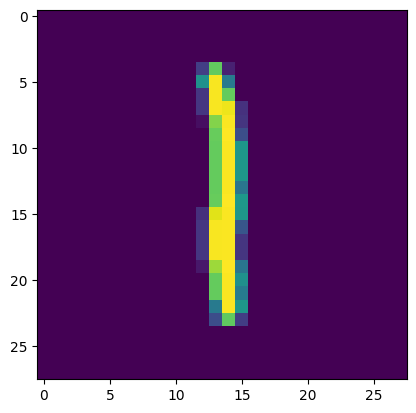

In [2]:
import matplotlib.pyplot as plt

rng, sub_rng = jax.random.split(rng)
i = jax.random.randint(sub_rng, (1,), 0, train_images.shape[0])
ex = train_images[i,:].reshape((28,28,1))
plt.imshow(ex)
plt.show()

### Now, we're going to train a fully-connected network to classify the digits

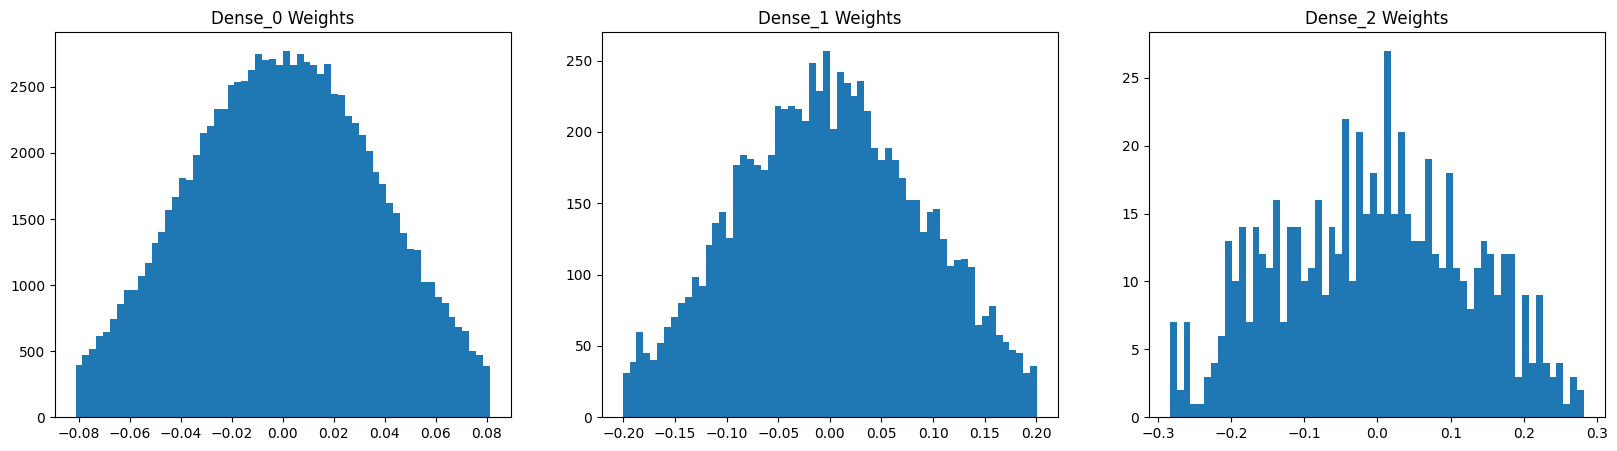

In [14]:
from typing import Dict, Any
from time import sleep

from flax import linen as nn
from flax.training import train_state
import optax

from matplotlib.animation import FuncAnimation


# Define the MLP model
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x, train: bool = True):
        x = nn.Dense(128)(x)             
        x = nn.BatchNorm(use_running_average=not train)(x)  # BatchNorm after Dense
        x = nn.relu(x)

        x = nn.Dense(64)(x)              
        x = nn.BatchNorm(use_running_average=not train)(x)  # BatchNorm after Dense
        x = nn.relu(x)

        x = nn.Dense(10)(x)              
        return x

model = MLP()
dummy_input = jnp.ones((32, 28*28))
variables = model.init(rng, dummy_input, train=True)
params = variables['params']
batch_stats = variables['batch_stats']


# Lets plot the initial model weight distributions
fig, axs = plt.subplots(1, 3, figsize=[20, 5])

dense0_w = params['Dense_0']['kernel'].flatten()
dense1_w = params['Dense_1']['kernel'].flatten()
dense2_w = params['Dense_2']['kernel'].flatten()

titles = ['Dense_0 Weights', 'Dense_1 Weights', 'Dense_2 Weights']

for ax, title in zip(axs, titles):
    ax.set_title(title)

axs[0].hist(dense0_w, bins=60)
axs[1].hist(dense1_w, bins=60)
axs[2].hist(dense2_w, bins=60)


plt.show()

In [15]:
params['BatchNorm_0']['bias'].shape

(128,)

In [20]:
import optax
from flax.training import train_state

LR = 0.01

# Create a train state
tx = optax.adam(learning_rate=LR)
ts = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

def compute_loss(params, batch_stats, apply_fn, images, labels, train):
    variables = {'params': params, 'batch_stats': batch_stats}
    logits, updated_variables = apply_fn(variables, images, train=train, mutable=['batch_stats'])
    one_hot_labels = jax.nn.one_hot(labels, 10)
    loss = optax.softmax_cross_entropy(logits, one_hot_labels).mean()
    return loss, updated_variables['batch_stats']

@jax.jit
def train_step(state, batch_stats, images, labels):
    def loss_fn(params):
        return compute_loss(params, batch_stats, state.apply_fn, images, labels, train=True)
    grads, updated_batch_stats = jax.grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, updated_batch_stats

#@jax.jit
def eval_step(params, batch_stats, apply_fn, images, labels):
    variables = {'params': params, 'batch_stats': batch_stats}
    logits = apply_fn(variables, images, train=False)
    predictions = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(predictions == labels)
    return accuracy


def train_and_evaluate(rng, model, ts, batch_stats, train_images, train_labels, test_images, test_labels):

    num_epochs = 50
    batch_size = 32
    num_train = train_images.shape[0]

    test_accuracy = eval_step(ts.params, batch_stats, ts.apply_fn, test_images, test_labels)
    print(f'Epoch 0 Test Accuracy: {test_accuracy:.4f}')
    params_history = [ts.params]
    batch_stats_history = [batch_stats]

    for epoch in range(num_epochs):

        rng, sub_rng = jax.random.split(rng)
        permutation = jax.random.permutation(sub_rng, num_train)
        train_images = train_images[permutation]
        train_labels = train_labels[permutation]
        
        for i in range(0, num_train, batch_size):
            batch_images = train_images[i:i + batch_size]
            batch_labels = train_labels[i:i + batch_size]
            ts, batch_stats = train_step(ts, batch_stats, batch_images, batch_labels)
        
        test_accuracy = eval_step(ts.params, batch_stats, ts.apply_fn, test_images, test_labels)
        print(f'Epoch {epoch + 1}, Test Accuracy: {test_accuracy:.4f}')
        params_history.append(ts.params)
        batch_stats_history.append(batch_stats)

    return params_history, batch_stats_history

params_history, batch_stats_history = train_and_evaluate(rng, model, ts, batch_stats, train_images, train_labels, test_images, test_labels)


Epoch 0 Test Accuracy: 0.0872
Epoch 1, Test Accuracy: 0.9631
Epoch 2, Test Accuracy: 0.9717
Epoch 3, Test Accuracy: 0.9737
Epoch 4, Test Accuracy: 0.9770
Epoch 5, Test Accuracy: 0.9761
Epoch 6, Test Accuracy: 0.9765
Epoch 7, Test Accuracy: 0.9755
Epoch 8, Test Accuracy: 0.9795
Epoch 9, Test Accuracy: 0.9810
Epoch 10, Test Accuracy: 0.9806
Epoch 11, Test Accuracy: 0.9806
Epoch 12, Test Accuracy: 0.9794
Epoch 13, Test Accuracy: 0.9788
Epoch 14, Test Accuracy: 0.9802
Epoch 15, Test Accuracy: 0.9813
Epoch 16, Test Accuracy: 0.9794
Epoch 17, Test Accuracy: 0.9826
Epoch 18, Test Accuracy: 0.9812
Epoch 19, Test Accuracy: 0.9817
Epoch 20, Test Accuracy: 0.9818
Epoch 21, Test Accuracy: 0.9807
Epoch 22, Test Accuracy: 0.9820
Epoch 23, Test Accuracy: 0.9780
Epoch 24, Test Accuracy: 0.9817
Epoch 25, Test Accuracy: 0.9814
Epoch 26, Test Accuracy: 0.9826
Epoch 27, Test Accuracy: 0.9810
Epoch 28, Test Accuracy: 0.9825
Epoch 29, Test Accuracy: 0.9823
Epoch 30, Test Accuracy: 0.9822
Epoch 31, Test Accu

In [21]:
import functools
import numpy as np
import matplotlib.animation as animation

# Output generated via `matplotlib.animation.Animation.to_jshtml`.
fig, ax = plt.subplots()
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()

def animate(frame, bar_container):
    # Simulate new data coming in.
    n, _ = np.histogram(frame, 60)
    for count, rect in zip(n, bar_container.patches):
        rect.set_height(count)

    return bar_container.patches

data = params_history[0]['Dense_2']['kernel'].flatten()
_, _, bar_container = ax.hist(data, 60, lw=1,
                              ec="yellow", fc="green", alpha=0.5)

frames = [ p['Dense_2']['kernel'].flatten() for p in params_history ]

anim = functools.partial(animate, bar_container=bar_container)
animation.FuncAnimation(fig, anim, frames, repeat=False, blit=True)